In [1]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision
import  torchvision.transforms as transforms

from PIL import Image
import cv2

from transformers import ResNetForImageClassification


In [2]:
#load pretrained resnet model
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])

In [3]:
readImg = 'images/eagle.jpeg'
# readImg = 'images/IndianElephant.jpg'
# readImg = 'images/Elephas_maximus.jpg'
img0 = Image.open(readImg).convert("RGB")

# CAM

In [ ]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(module, input, output):
        activation[name] = output.detach().cpu().numpy()
    return hook

In [ ]:
model.resnet.encoder.stages[-1].register_forward_hook(getActivation('last_stage'))

In [ ]:
params = list(model.classifier[1].parameters())

weight = np.squeeze(params[0].data.numpy())


In [ ]:
def return_CAM(feature_conv, weight, class_idx):
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [ ]:
model.eval()
logit = model(transform(img0).unsqueeze(0)).logits

In [ ]:
h_x = F.softmax(logit, dim=1).data.squeeze()

probs, idx = h_x.sort(0, True)
probs = probs.detach().numpy()
idx = idx.numpy()

In [ ]:
CAMs = return_CAM(activation['last_stage'], weight, [idx[0]])

In [ ]:
img = cv2.imread(readImg)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.5 + img * 0.5

cv2.imwrite("image_1.jpg", result)

In [ ]:
model.config.id2label[idx[0]]

# Grad-CAM

In [4]:
# defines two global scope variables to store our gradients and activations
gradients = {}
activations = {}

def getGradients(name):
    def backward_hook(module, grad_input, grad_output):
        gradients[name] = grad_output
    return backward_hook

def getActivations(name):
    def forward_hook(module, args, output):
        activations[name] = output
    return forward_hook

In [5]:
backward_hook = model.resnet.encoder.stages[-1].layers[-1].register_backward_hook(getGradients('lastLayer'))
forward_hook = model.resnet.encoder.stages[-1].layers[-1].register_forward_hook(getActivations('lastLayer'))

In [6]:
model.eval()
logit = model(transform(img0).unsqueeze(0)).logits

/home/administrator/.local/lib/python3.7/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [7]:
h_x = F.softmax(logit, dim=1).data.squeeze()

probs, idx = h_x.sort(0, True)
probs = probs.detach().numpy()
idx = idx.numpy()
model.config.id2label[idx[0]]

'kite'

In [8]:
logit[0,idx[0]].backward()

In [9]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients['lastLayer'][0], dim=[0, 2, 3])


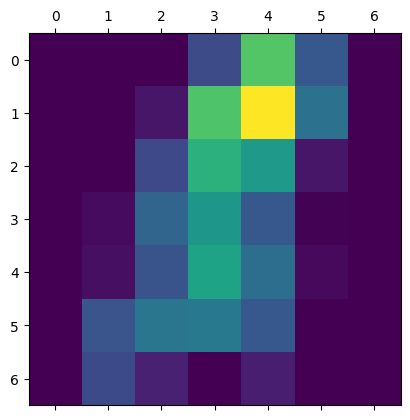

In [10]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# weight the channels by corresponding gradients
for i in range(activations['lastLayer'].size()[1]):
    activations['lastLayer'][:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations['lastLayer'], dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap).detach().cpu().numpy()

# normalize the heatmap
heatmap = heatmap - np.min(heatmap)
heatmap_img = heatmap / np.max(heatmap)
heatmap_img = np.uint8(255 * heatmap_img)

# draw the heatmap
plt.matshow(heatmap_img)

In [11]:
img = cv2.imread(readImg)
height, width, _ = img.shape
_heatmap = cv2.applyColorMap(cv2.resize(heatmap_img,(width, height)), cv2.COLORMAP_JET)
result = _heatmap * 0.5 + img * 0.5

cv2.imwrite("image_1.jpg", result)

True